In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl

from src.visualization import plot_data
from src.preprocess import process_label


plt.style.use("tableau-colorblind10")

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))

[PosixPath('../../../input/hms-harmful-brain-activity-classification/test_eegs'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/test.csv'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/example_figures'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/test_spectrograms'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/train_spectrograms'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/sample_submission.csv'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/train_eegs'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/train.csv')]

In [3]:
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)

## 固有なデータの分布について

In [4]:
metadata["eeg_id"].unique().shape

(17089,)

In [5]:
metadata["spectrogram_id"].unique().shape

(11138,)

In [6]:
metadata["label_id"].unique().shape

(106800,)

調べる項目:

- uniqueな`eeg_id`の数
- `eeg_id` あたりの`eeg_sub_id`の数の分布
- `eeg_id` と `sprctrogram_id` の対応が1:1でないものが存在しないこと
- ラベルごとの分布(`seizure_vote`, `lpd_vote`, `gpd_vote`, `lrda_vote`, `grda_vote`, `other_vote`)

memo:

- 1つのEEG/spectrogramに対し、特定のoffsetについて50secの範囲を切り取って診断しているっぽい。前者は`eeg_id`/`spectrogram_id`で、後者は`eeg_sub_id`/`spectrogram_sub_id`で管理しているっぽい。
- 同じIDのEEGのグループ特徴とクローズアップしたsub-EEGの特徴を両方加味して診断を下しているっぽい(competition pageの説明にも「5secのEEGを見るとRDAだが、50secのspectrogramを見るとseizureの終わりのタイミングだから両方のラベルがついている」といった内容の記述がある。)

確認したい:

- EEG/spectrogramの範囲は完全に一致しているのか？

findings

- ノイズすごい -> rolling meanをとる
- データのrangeが広すぎる
    - 電極が外れたりしている？
    - まさかとは思うがオシロスコープのdynamicレンジの電圧をそのままデータとしている？


In [7]:
eeg_id = 1628180742
eeg = pl.read_parquet(data_dir / f"train_eegs/{eeg_id}.parquet")

In [8]:
eeg.head()

shape: (5, 20)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Fp1       ┆ F3        ┆ C3        ┆ P3        ┆ … ┆ T4        ┆ T6        ┆ O2        ┆ EKG      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f32       ┆ f32       ┆ f32       ┆ f32       ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -80.51999 ┆ -70.54000 ┆ -80.11000 ┆ -108.75   ┆ … ┆ -98.36000 ┆ -121.7300 ┆ -106.4499 ┆ 7.92     │
│ 7         ┆ 1         ┆ 1         ┆           ┆   ┆ 1         ┆ 03        ┆ 97        ┆          │
│ -80.44999 ┆ -70.33000 ┆ -81.76000 ┆ -107.6699 ┆ … ┆ -89.29000 ┆ -115.5    ┆ -102.0599 ┆ 29.21999 │
│ 7         ┆ 2         ┆ 2         ┆ 98        ┆   ┆ 1         ┆           ┆ 98        ┆ 9        │
│ -80.20999 ┆ -75.87000 ┆ -82.05000 ┆ -106.0100 ┆ … ┆ -96.01999 ┆ -123.8799 ┆ -105.7900 ┆ 45.74000 │
│ 9         ┆ 3         ┆ 3         ┆ 02        ┆   ┆ 7         ┆ 97        ┆ 01        ┆ 2        │
│ -84.70999 ┆ -75.33999 ┆ -87.48000 ┆ -108.9700 ┆ … ┆ -97.18    ┆ -128.9400 ┆ -109.8899 ┆ 83.87000 │
│ 9         ┆ 6         ┆ 3         ┆ 01        ┆   ┆           ┆ 02        ┆ 99        ┆ 3        │
│ -90.57    ┆ -80.79000 ┆ -93.0     ┆ -113.8700 ┆ … ┆ -88.73000 ┆ -114.8499 ┆ -100.25   ┆ 97.76999 │
│           ┆ 1         ┆           ┆ 03        ┆   ┆ 3         ┆ 98        ┆           ┆ 7        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

label_id=4277921496, eeg_id=4249475128, eeg_sub_id=36, spectrogram_id=617579510
spectrogram_offset_sec=240.0, eeg_offset_sec=240.0


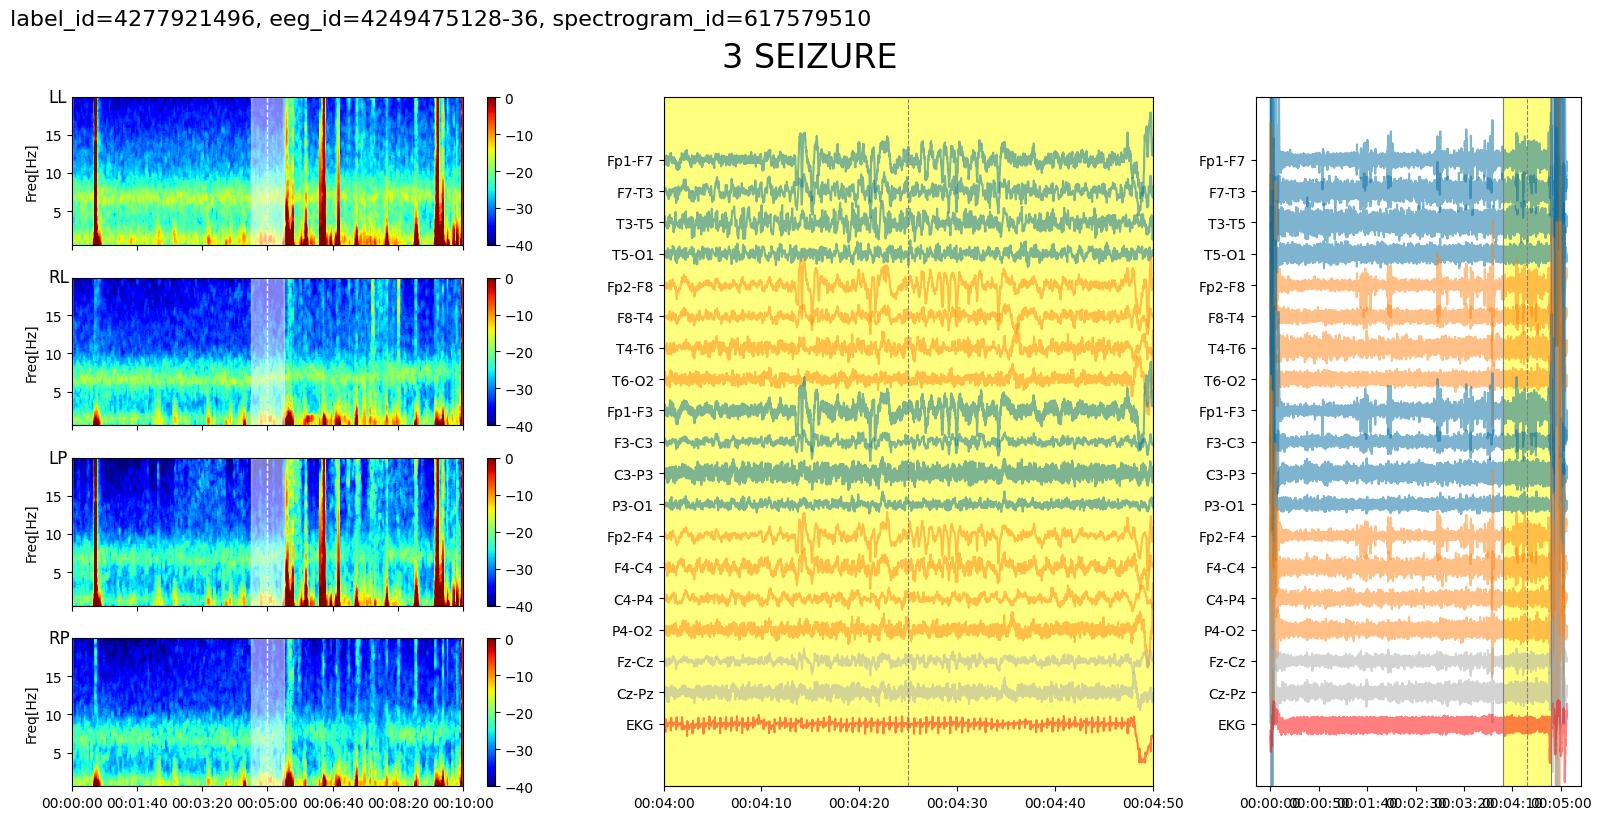

label_id=1946867081, eeg_id=3839609639, eeg_sub_id=0, spectrogram_id=699287805
spectrogram_offset_sec=0.0, eeg_offset_sec=0.0


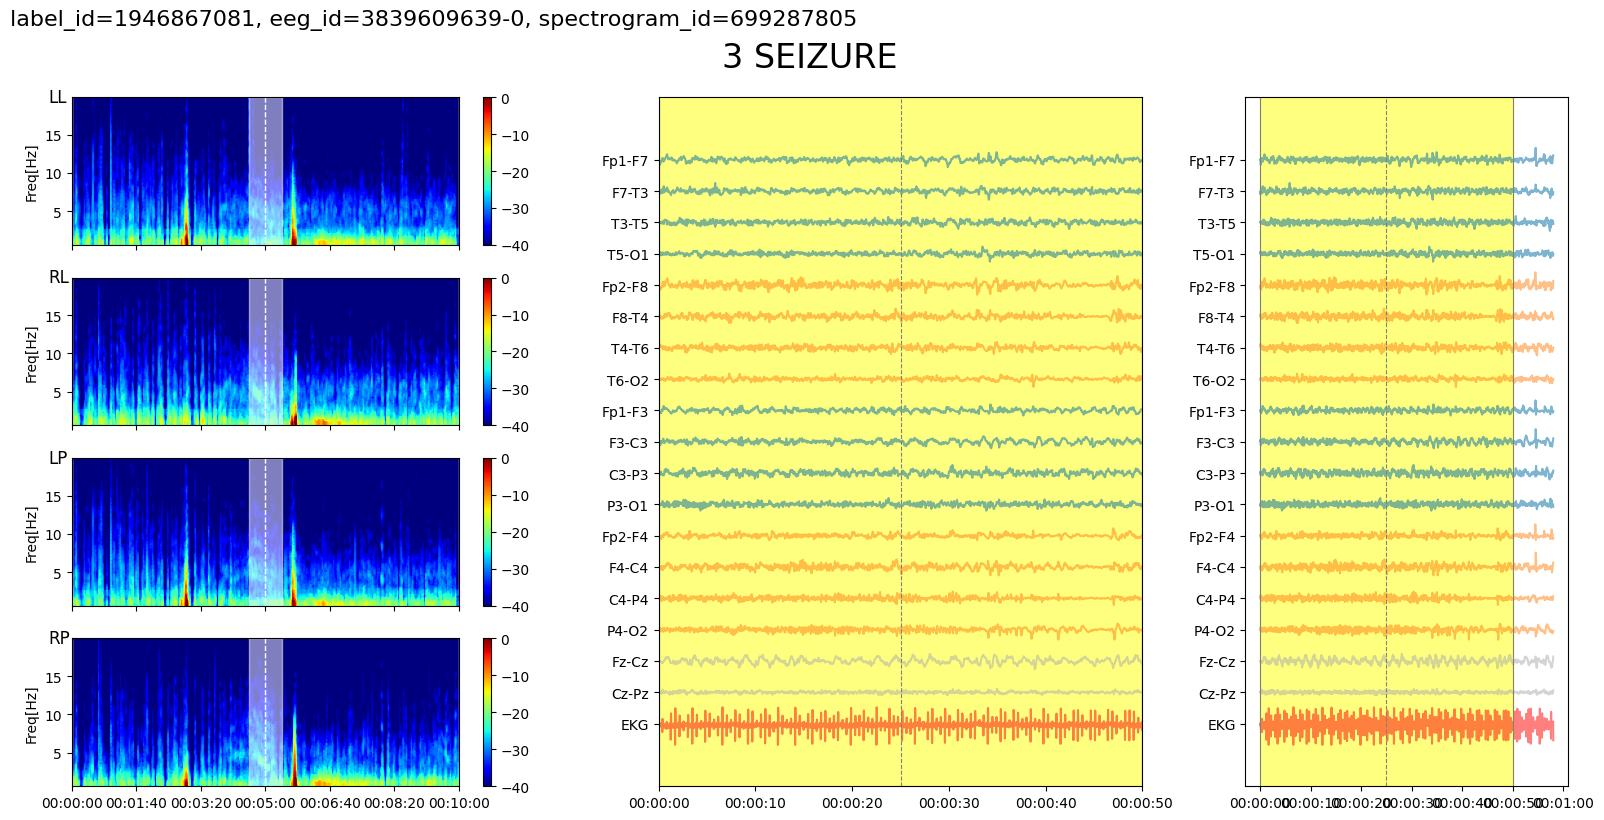

label_id=1009905417, eeg_id=484116091, eeg_sub_id=4, spectrogram_id=1877615544
spectrogram_offset_sec=8.0, eeg_offset_sec=8.0


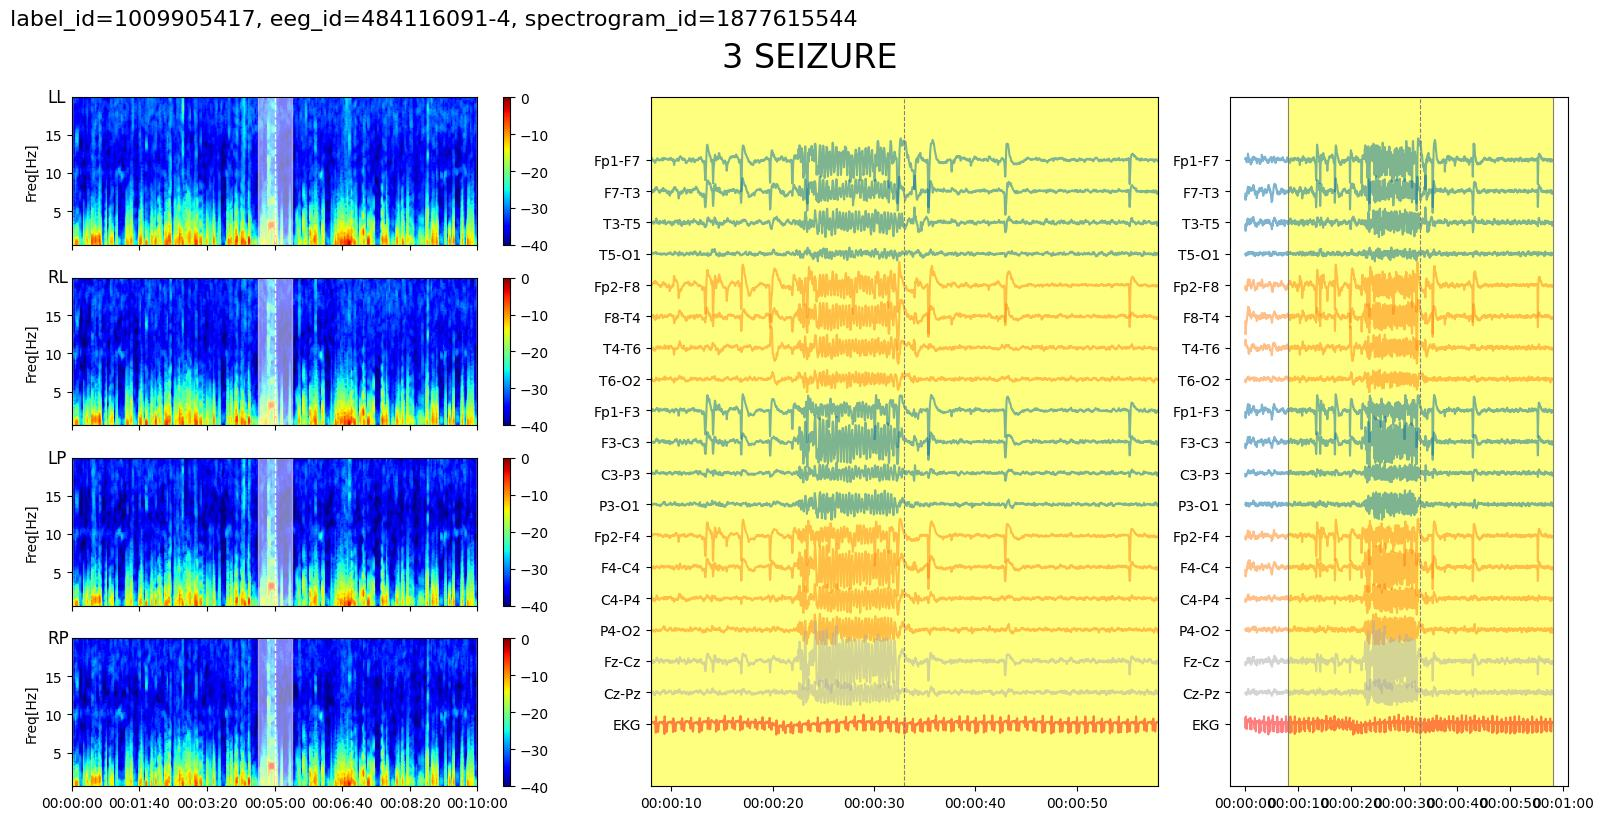

label_id=1228828918, eeg_id=2383233693, eeg_sub_id=12, spectrogram_id=1517158948
spectrogram_offset_sec=274.0, eeg_offset_sec=114.0


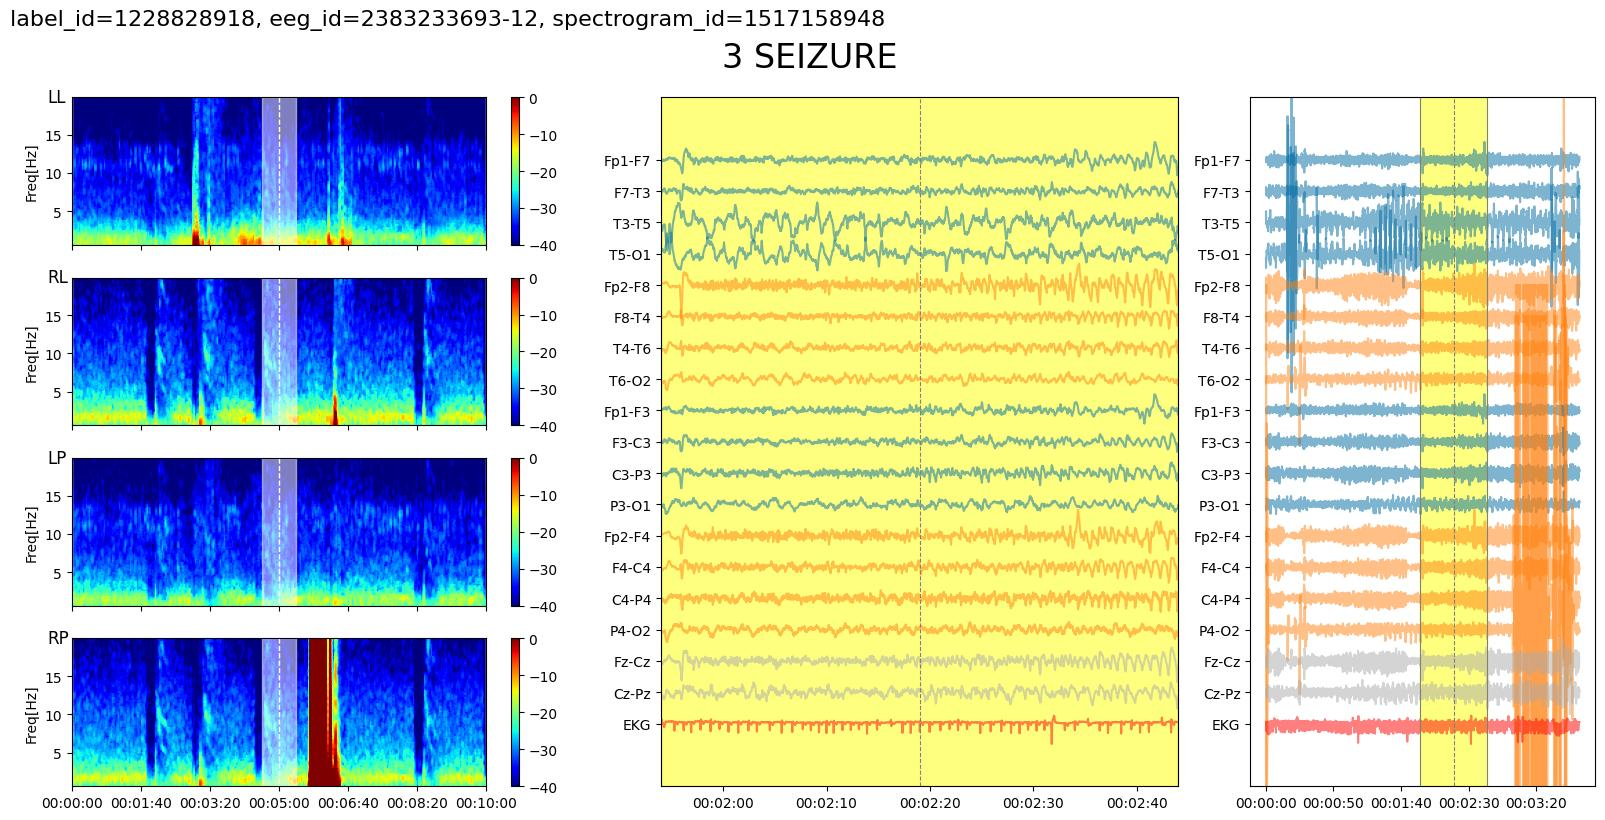

label_id=1694950035, eeg_id=3442182362, eeg_sub_id=8, spectrogram_id=2090831991
spectrogram_offset_sec=52.0, eeg_offset_sec=52.0


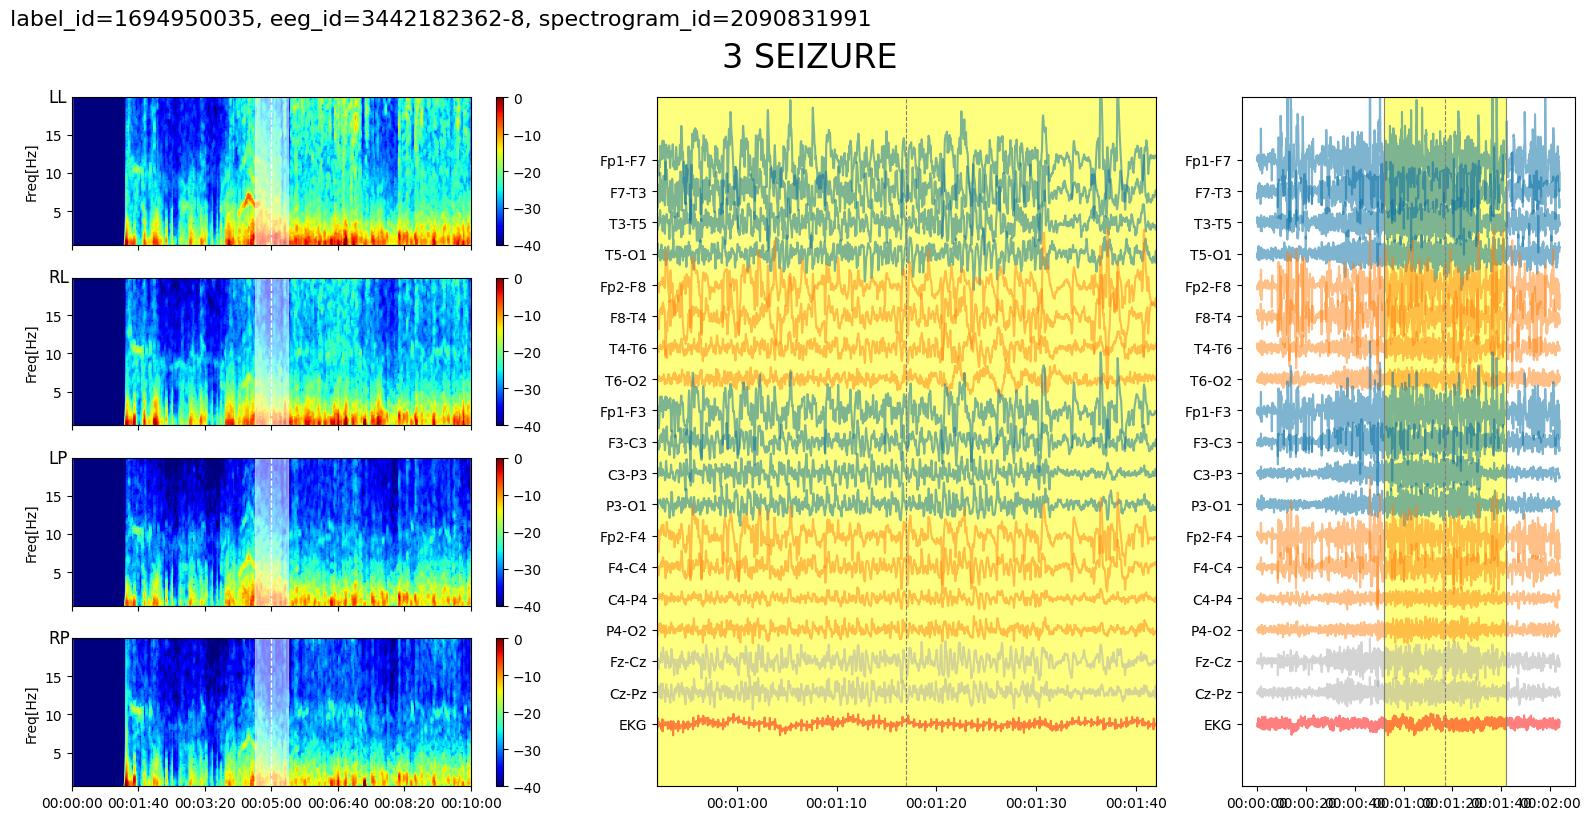

label_id=1710422578, eeg_id=2309386630, eeg_sub_id=5, spectrogram_id=595701076
spectrogram_offset_sec=30.0, eeg_offset_sec=30.0


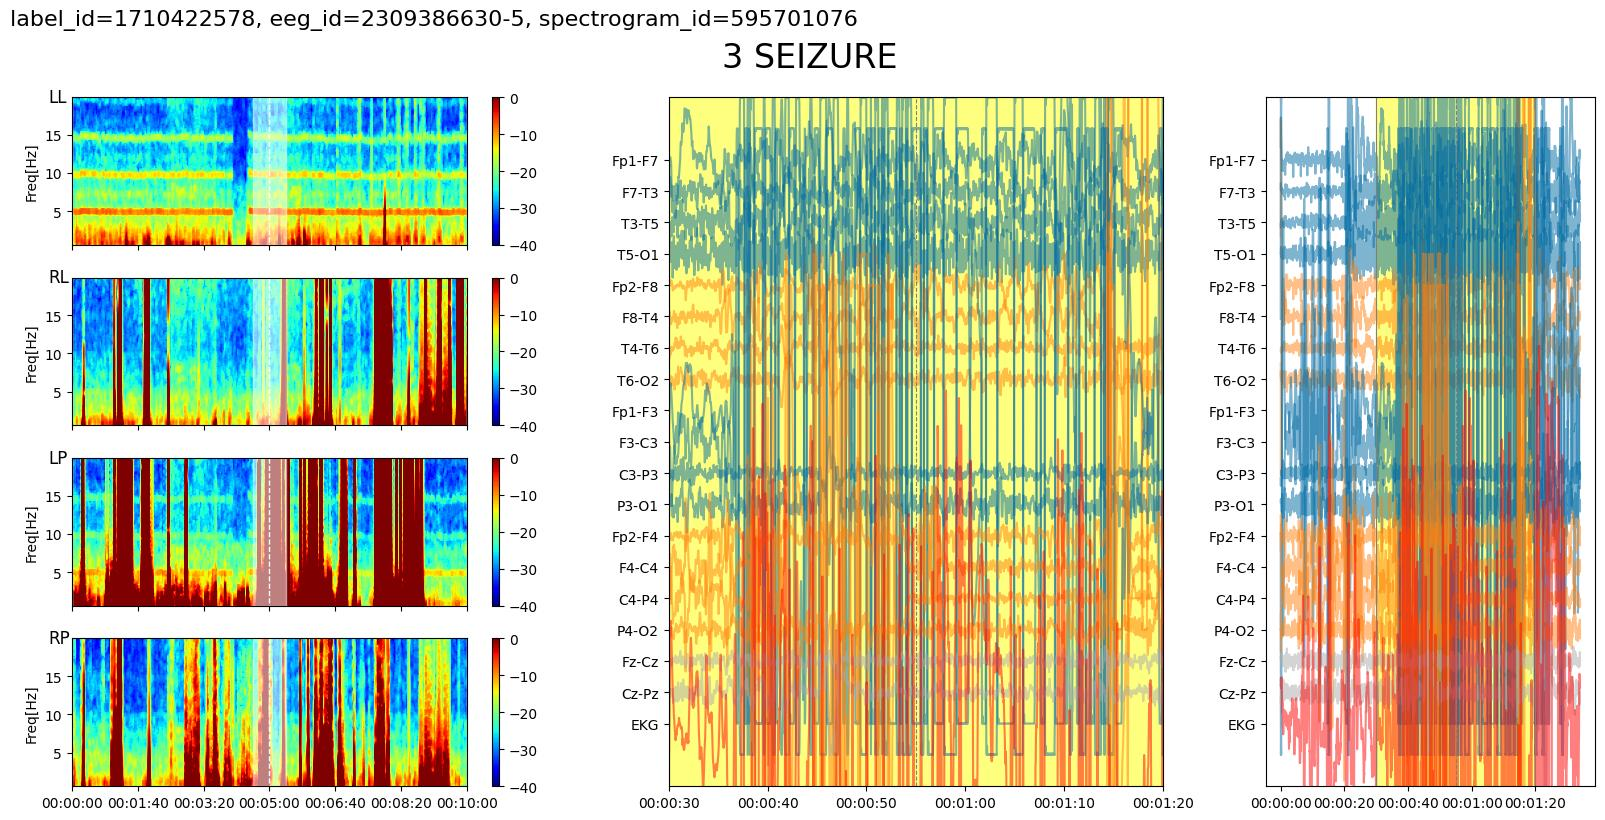

label_id=1120263495, eeg_id=3130428145, eeg_sub_id=1, spectrogram_id=1223938368
spectrogram_offset_sec=2.0, eeg_offset_sec=2.0


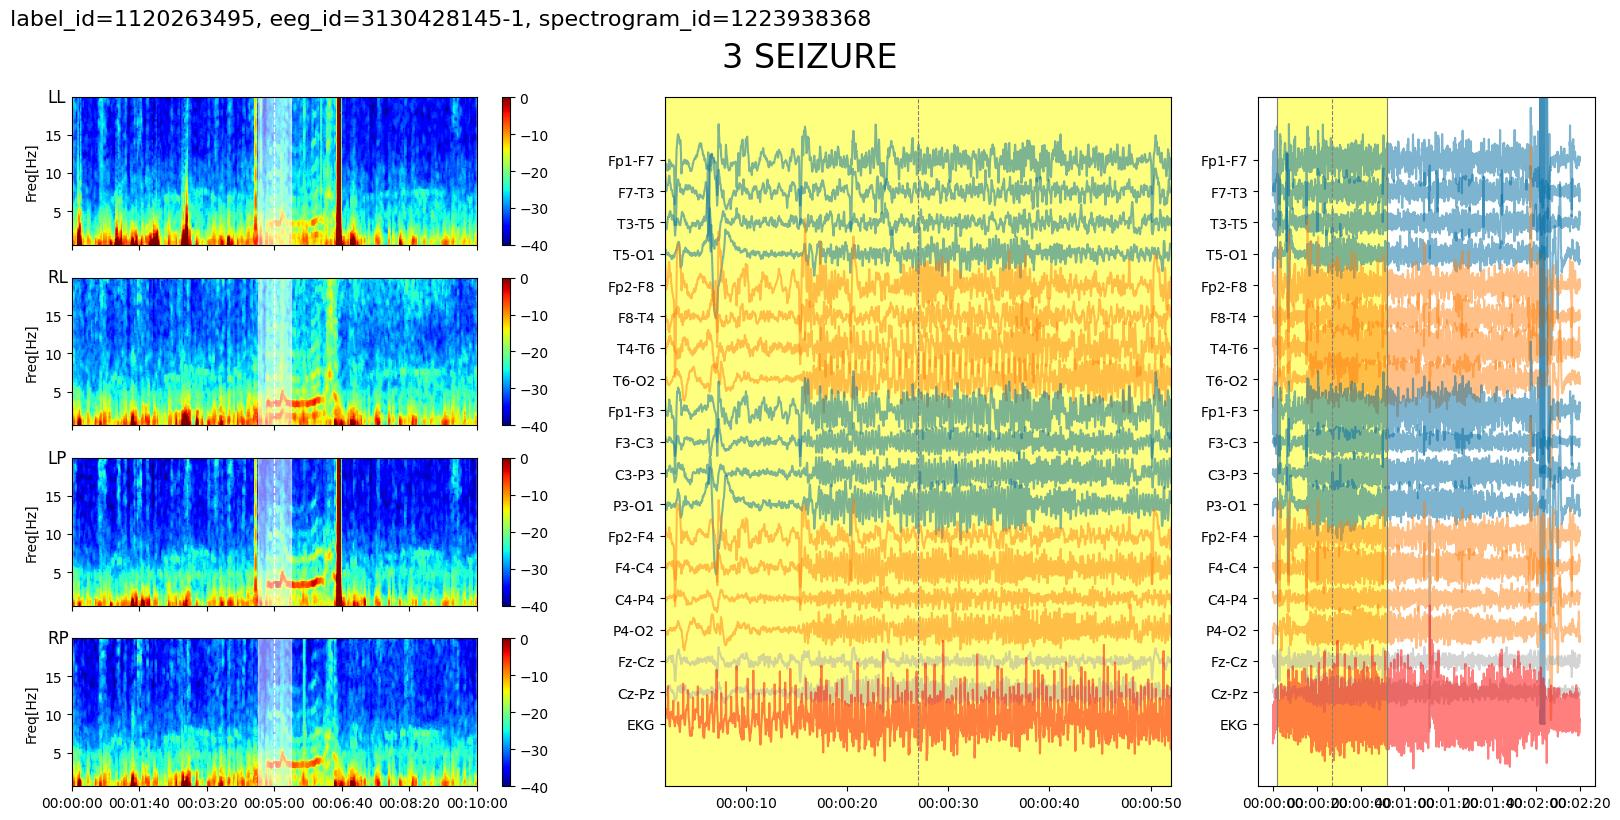

label_id=335611429, eeg_id=25239347, eeg_sub_id=9, spectrogram_id=625758821
spectrogram_offset_sec=110.0, eeg_offset_sec=110.0


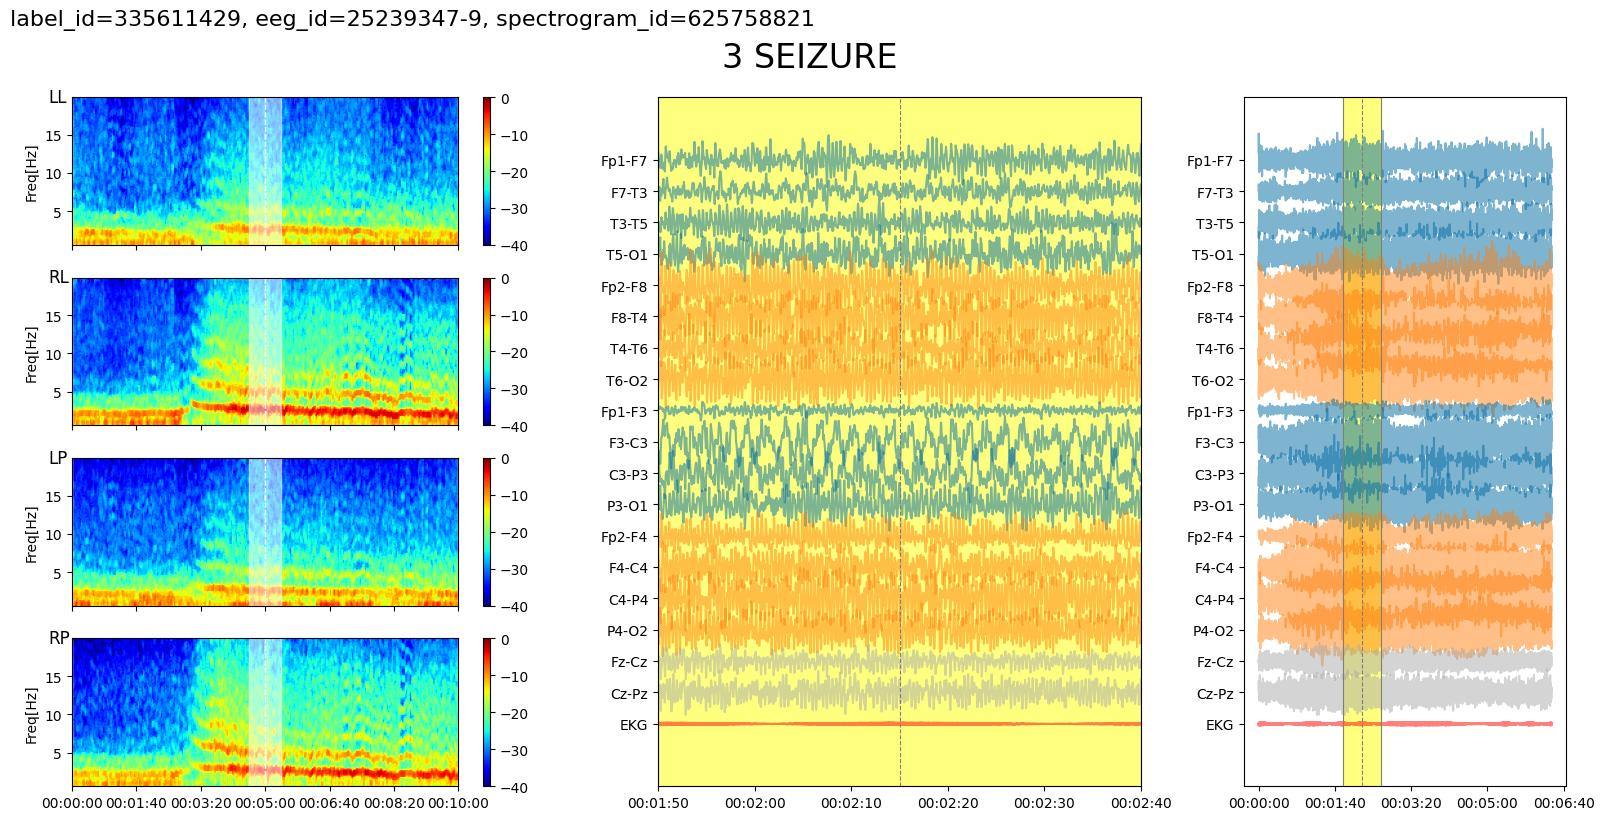

label_id=3066120888, eeg_id=151923573, eeg_sub_id=6, spectrogram_id=819812287
spectrogram_offset_sec=14.0, eeg_offset_sec=14.0


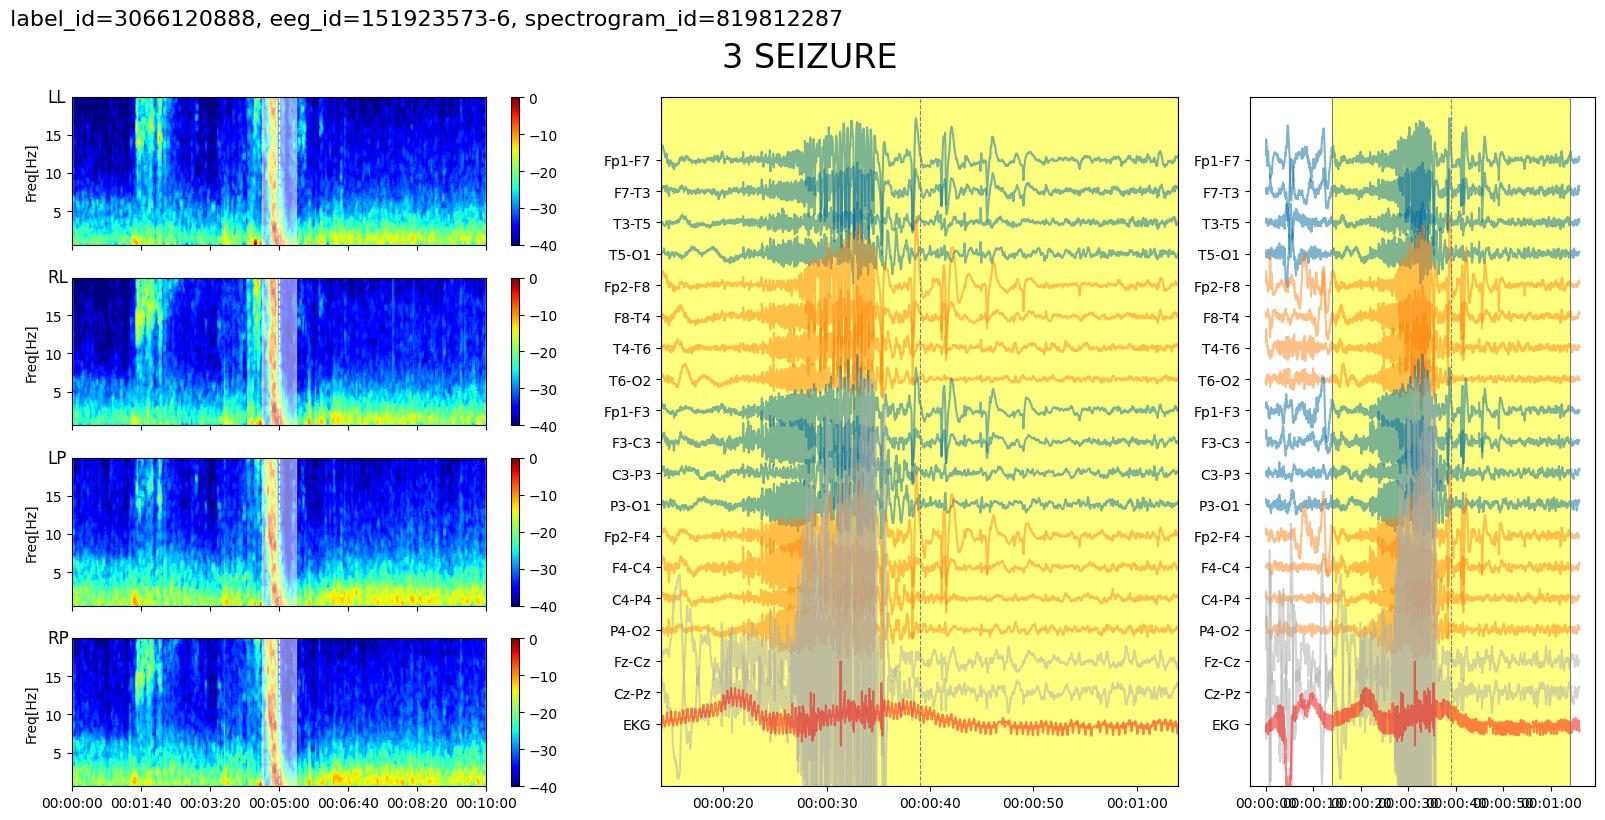

label_id=2940725537, eeg_id=3724256537, eeg_sub_id=3, spectrogram_id=2111233918
spectrogram_offset_sec=20.0, eeg_offset_sec=20.0


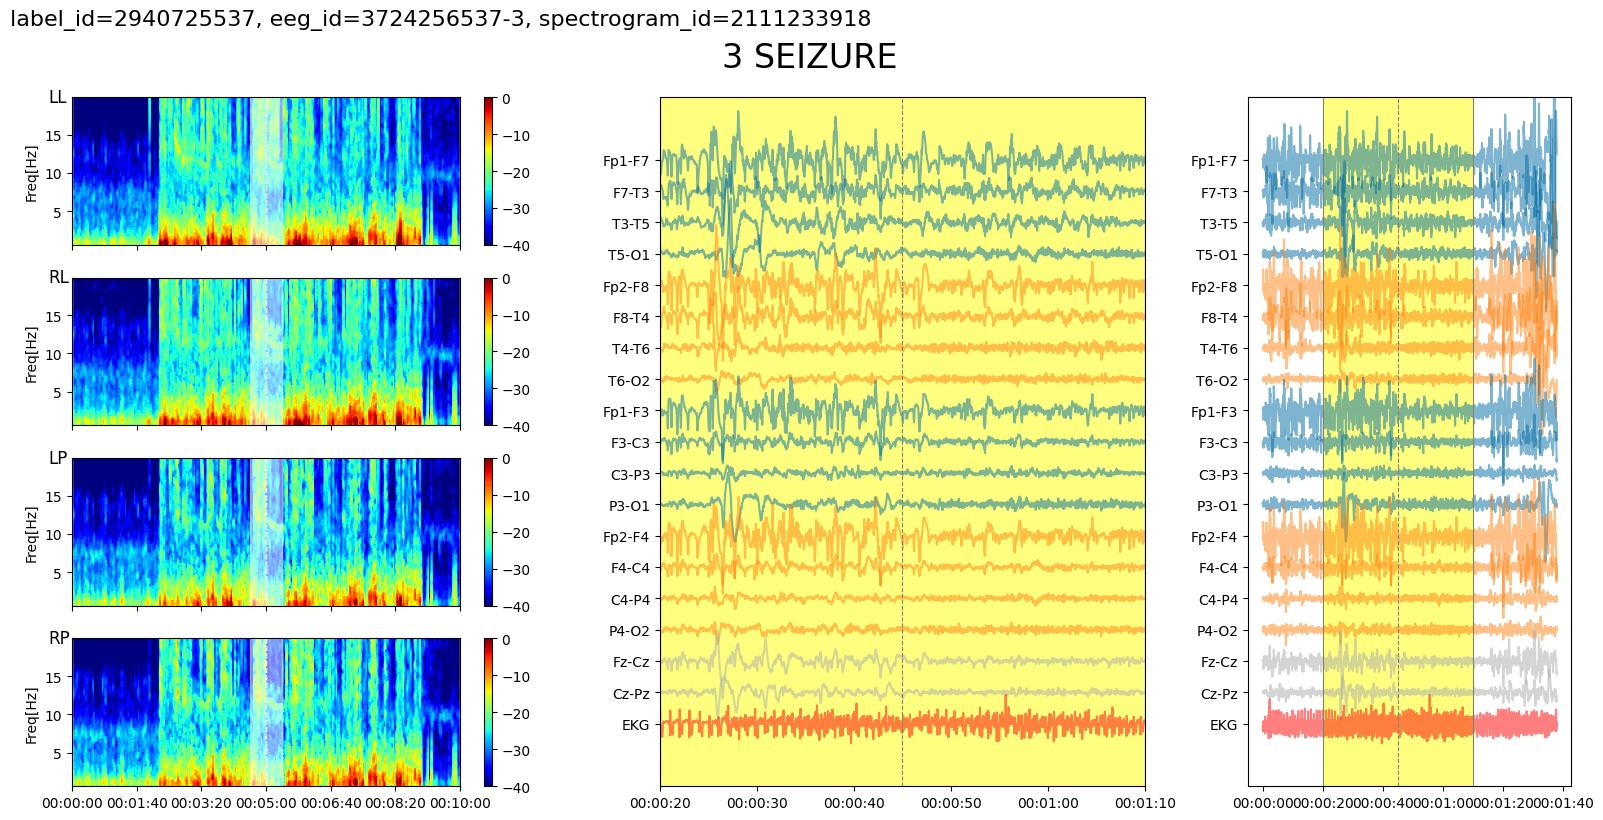

In [11]:
columns = metadata.columns
for row in metadata.filter(
        pl.col("weight")
        .ge(0.1)
        .and_(pl.col("weight").lt(0.3)).and_(pl.col("expert_consensus").eq("Seizure"))
    ).sample(10).iter_rows():
    row = dict(zip(columns, row))
    eeg_id = row["eeg_id"]
    eeg_sub_id = row["eeg_sub_id"]
    plot_data(metadata, eeg_id, eeg_sub_id, cutoff_freqs=(0.5, 50))
    plt.show()

label_id=1895687890, eeg_id=3945687482, eeg_sub_id=0, spectrogram_id=716859663
spectrogram_offset_sec=0.0, eeg_offset_sec=0.0


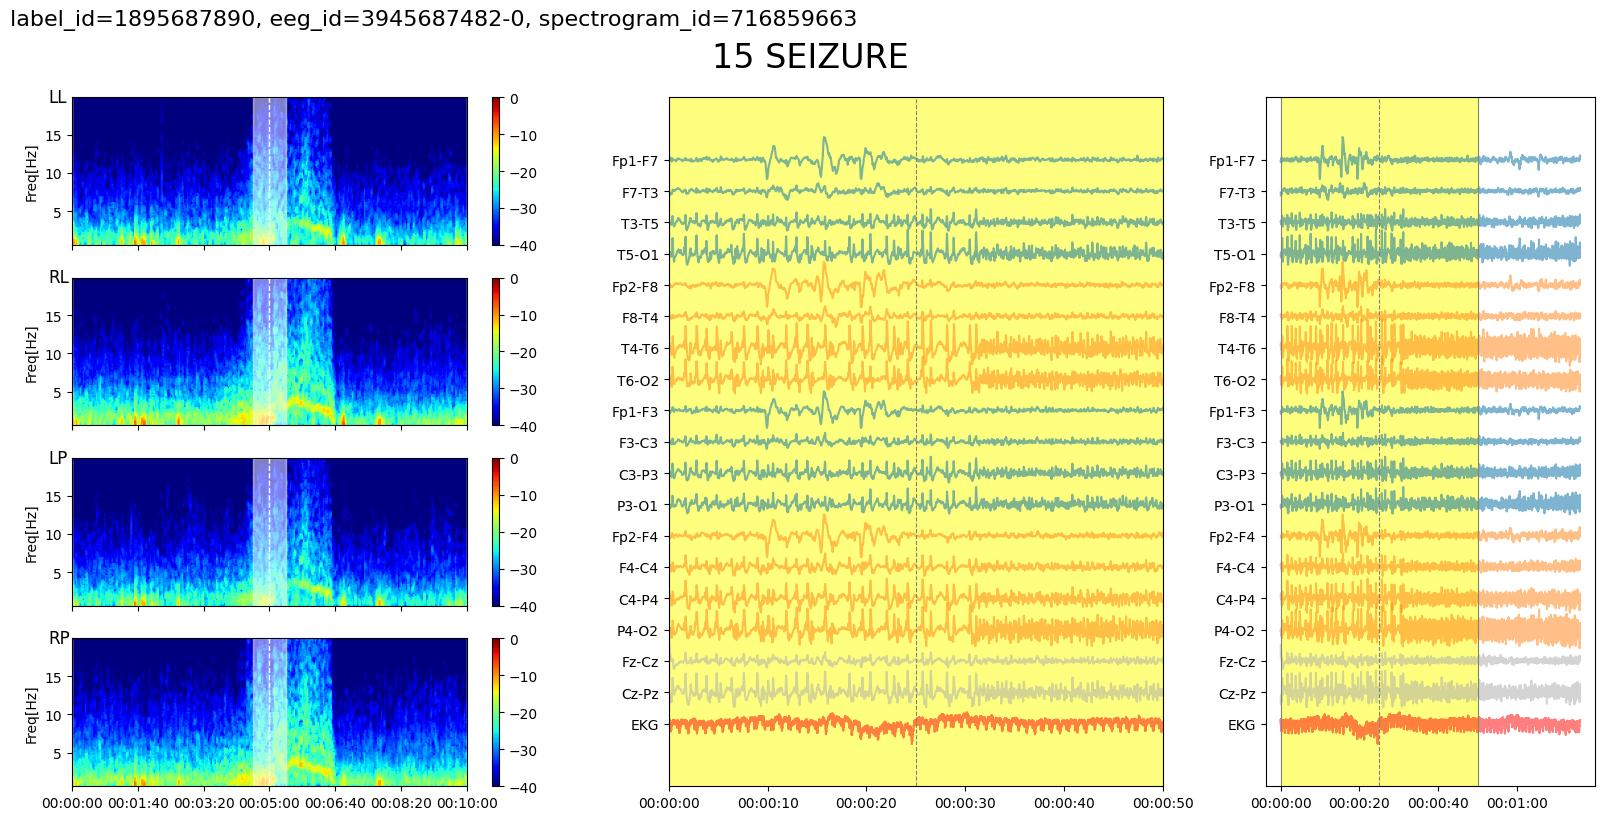

label_id=2445859295, eeg_id=2352174329, eeg_sub_id=2, spectrogram_id=440390579
spectrogram_offset_sec=4.0, eeg_offset_sec=4.0


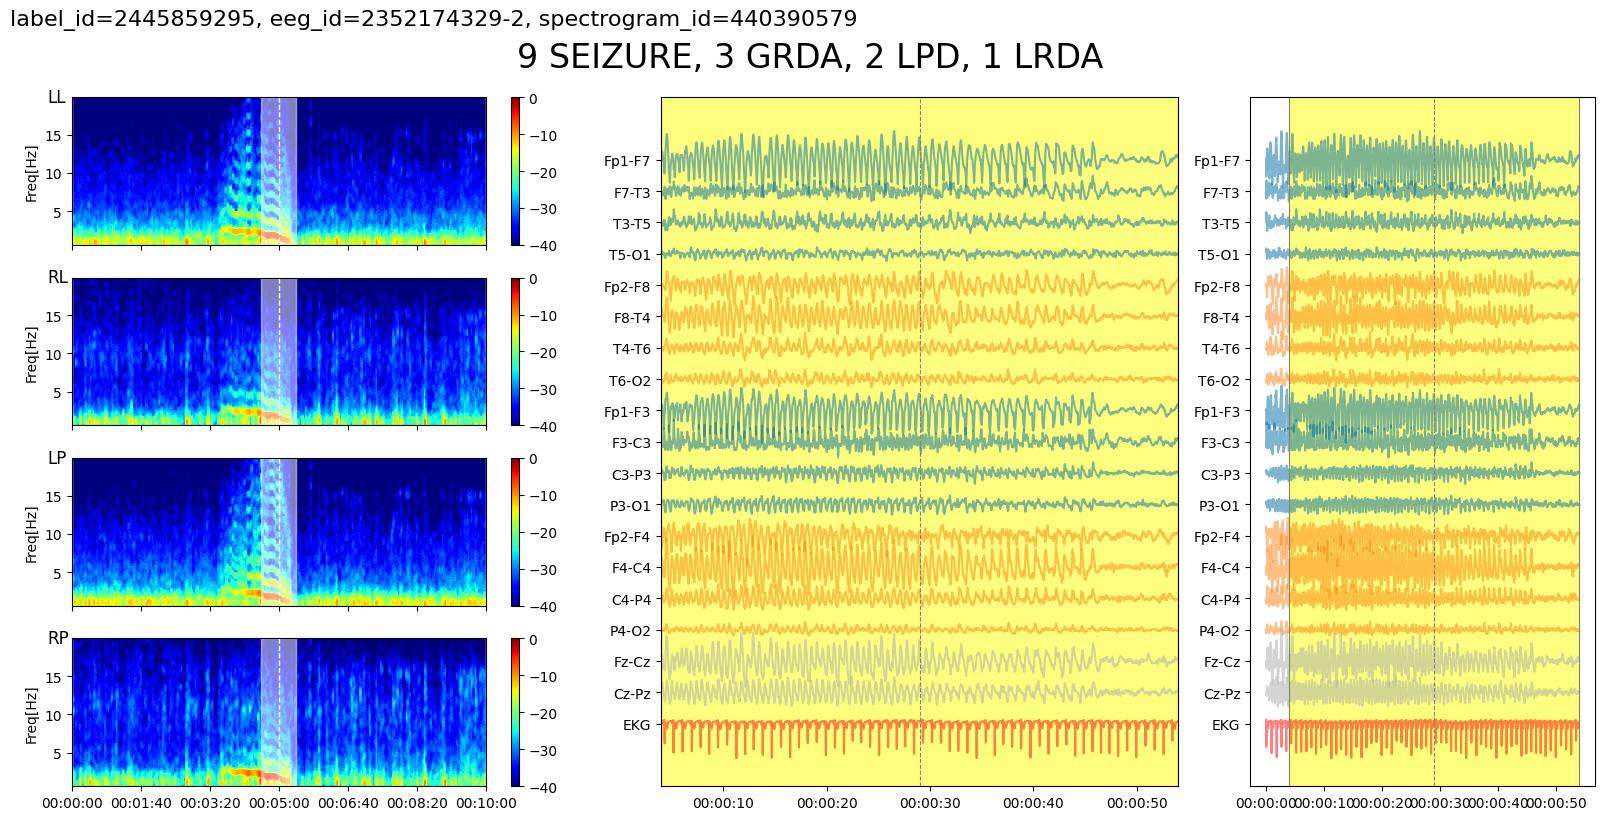

label_id=855849853, eeg_id=626664146, eeg_sub_id=0, spectrogram_id=1391320121
spectrogram_offset_sec=0.0, eeg_offset_sec=0.0


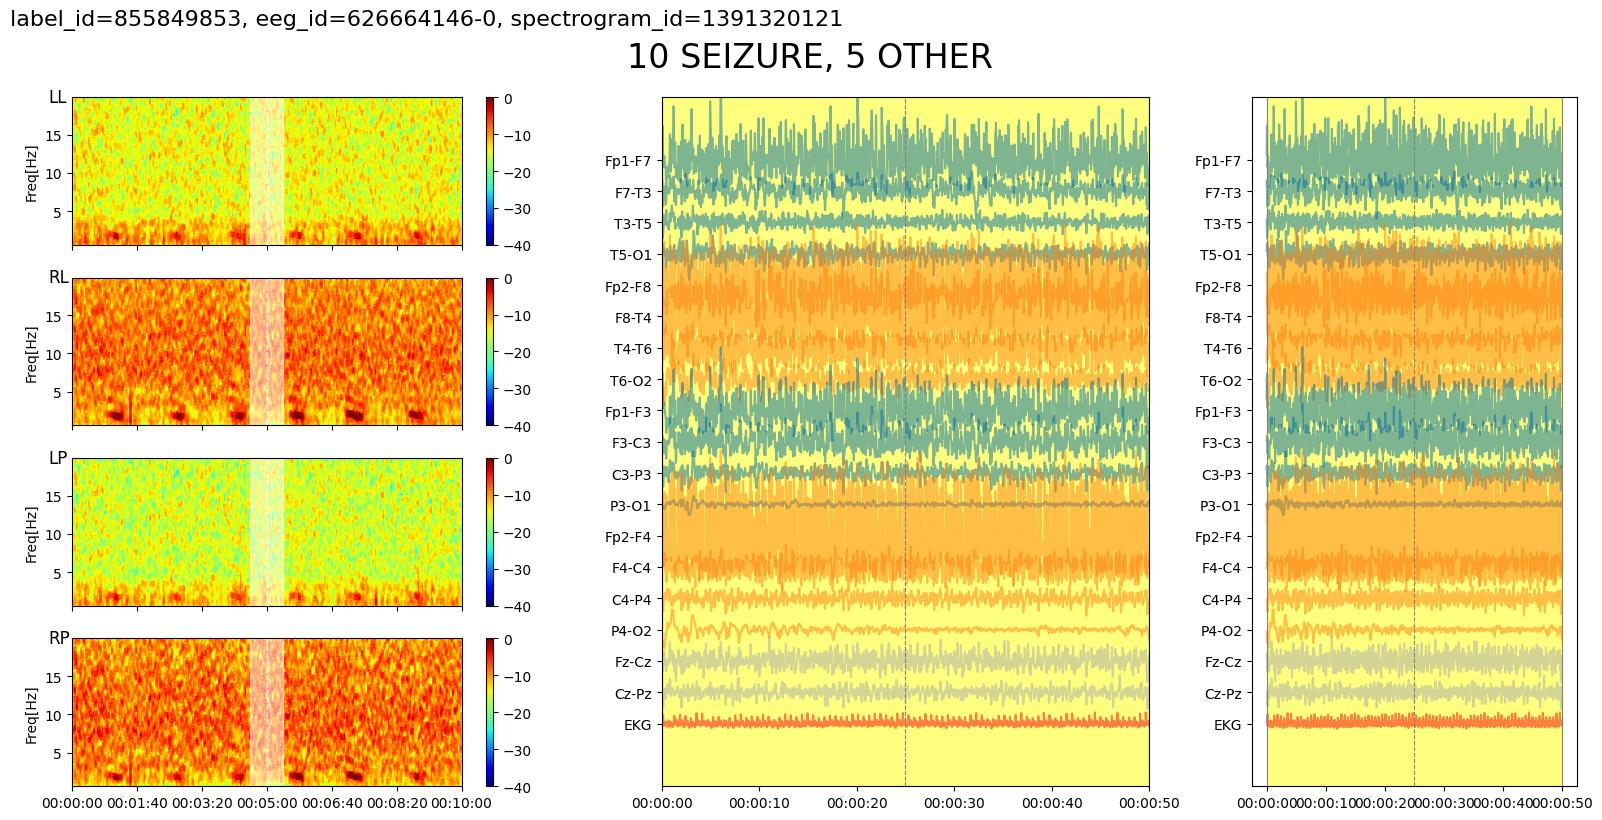

label_id=2542854533, eeg_id=1187848371, eeg_sub_id=2, spectrogram_id=466166928
spectrogram_offset_sec=4.0, eeg_offset_sec=4.0


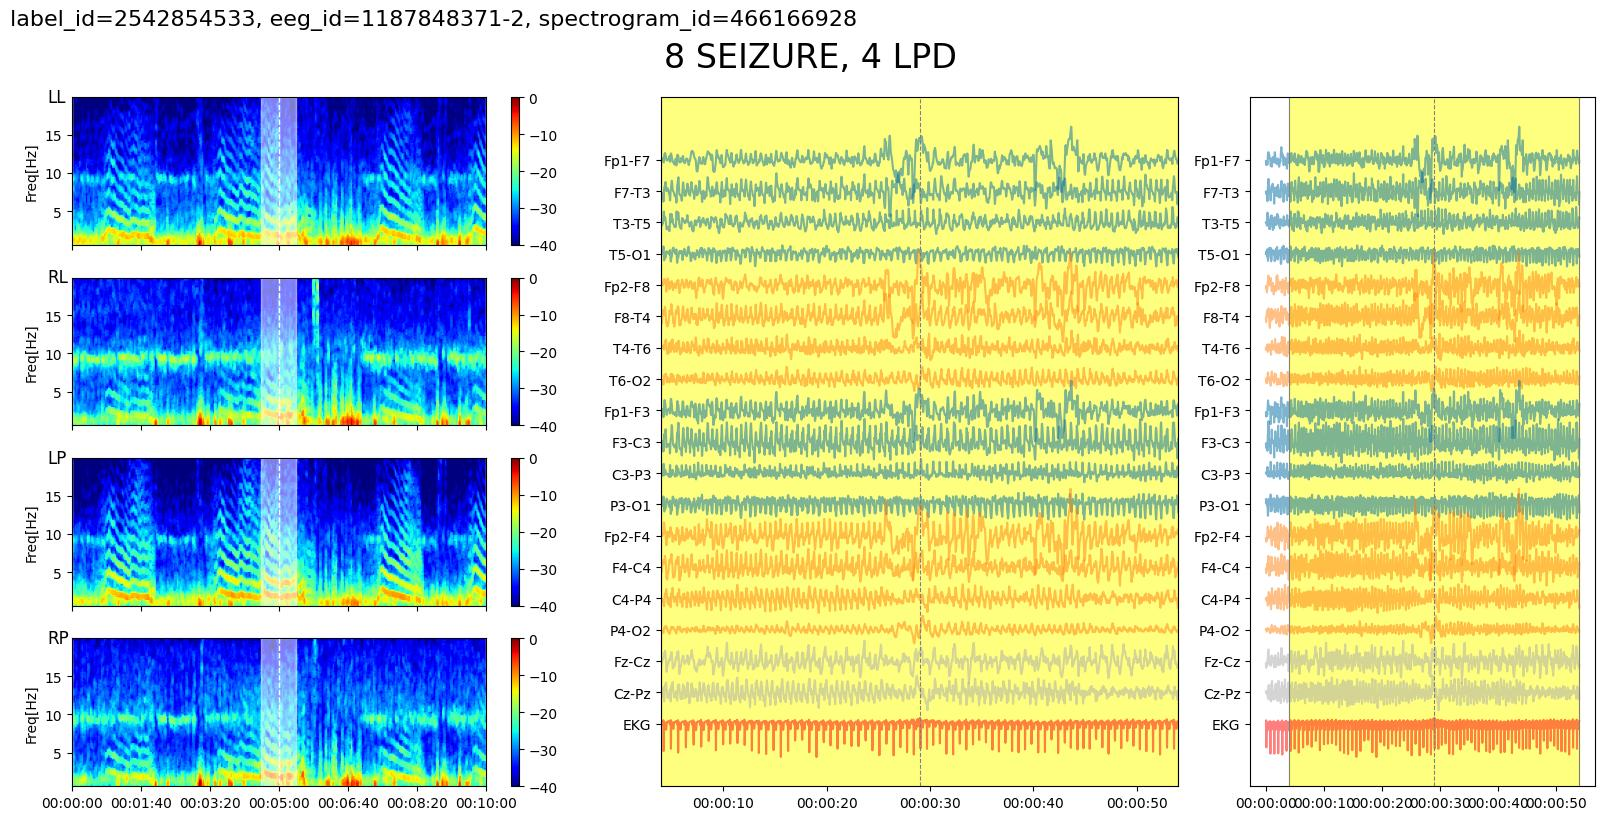

label_id=1153555356, eeg_id=919299059, eeg_sub_id=1, spectrogram_id=656460159
spectrogram_offset_sec=20.0, eeg_offset_sec=20.0


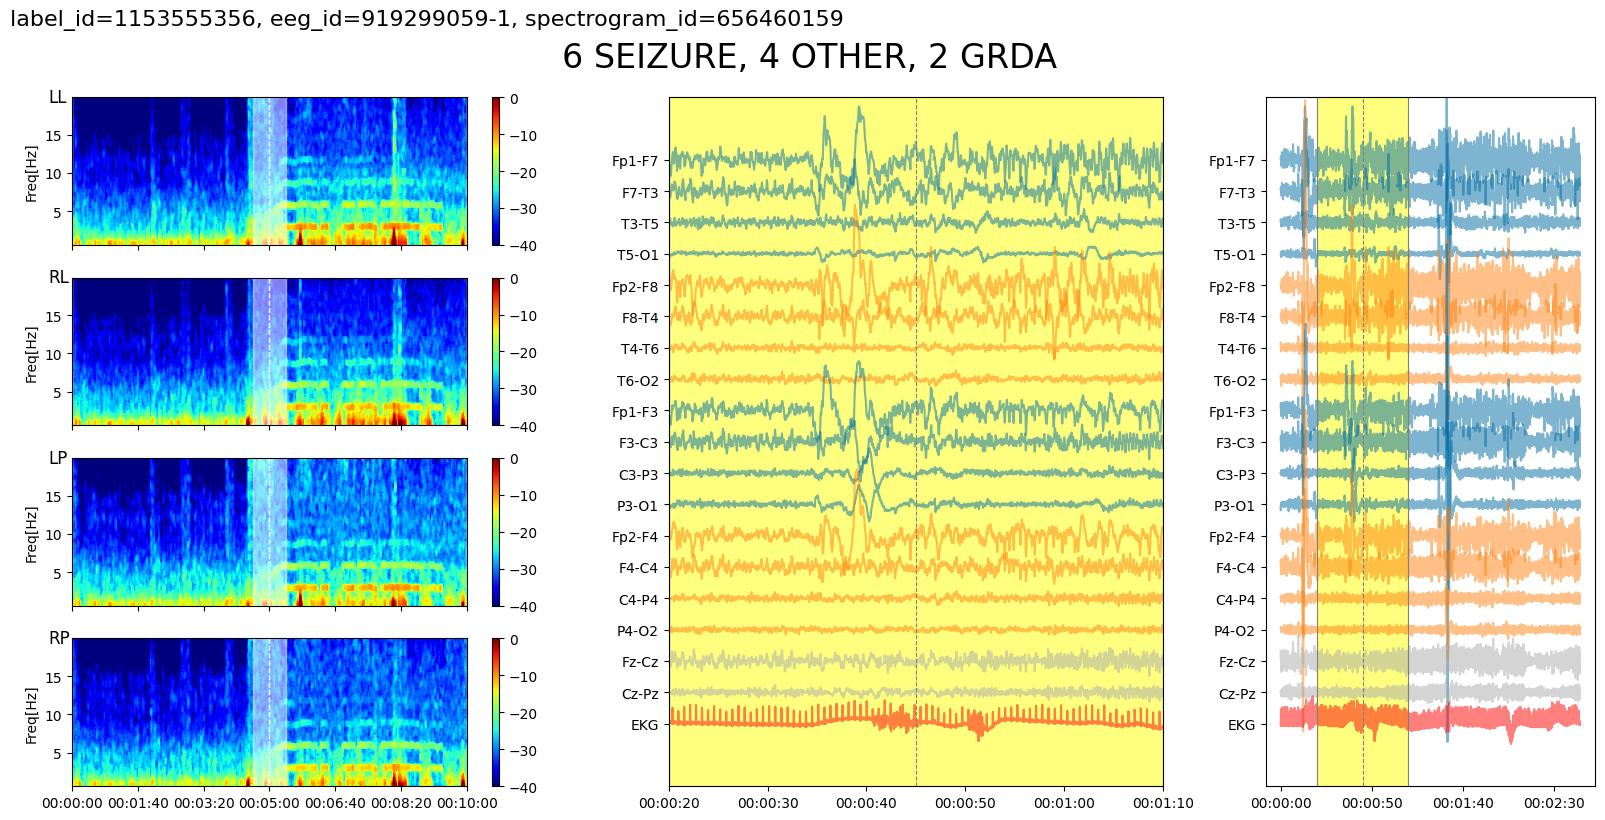

label_id=2649777310, eeg_id=872511922, eeg_sub_id=0, spectrogram_id=1164826488
spectrogram_offset_sec=0.0, eeg_offset_sec=0.0


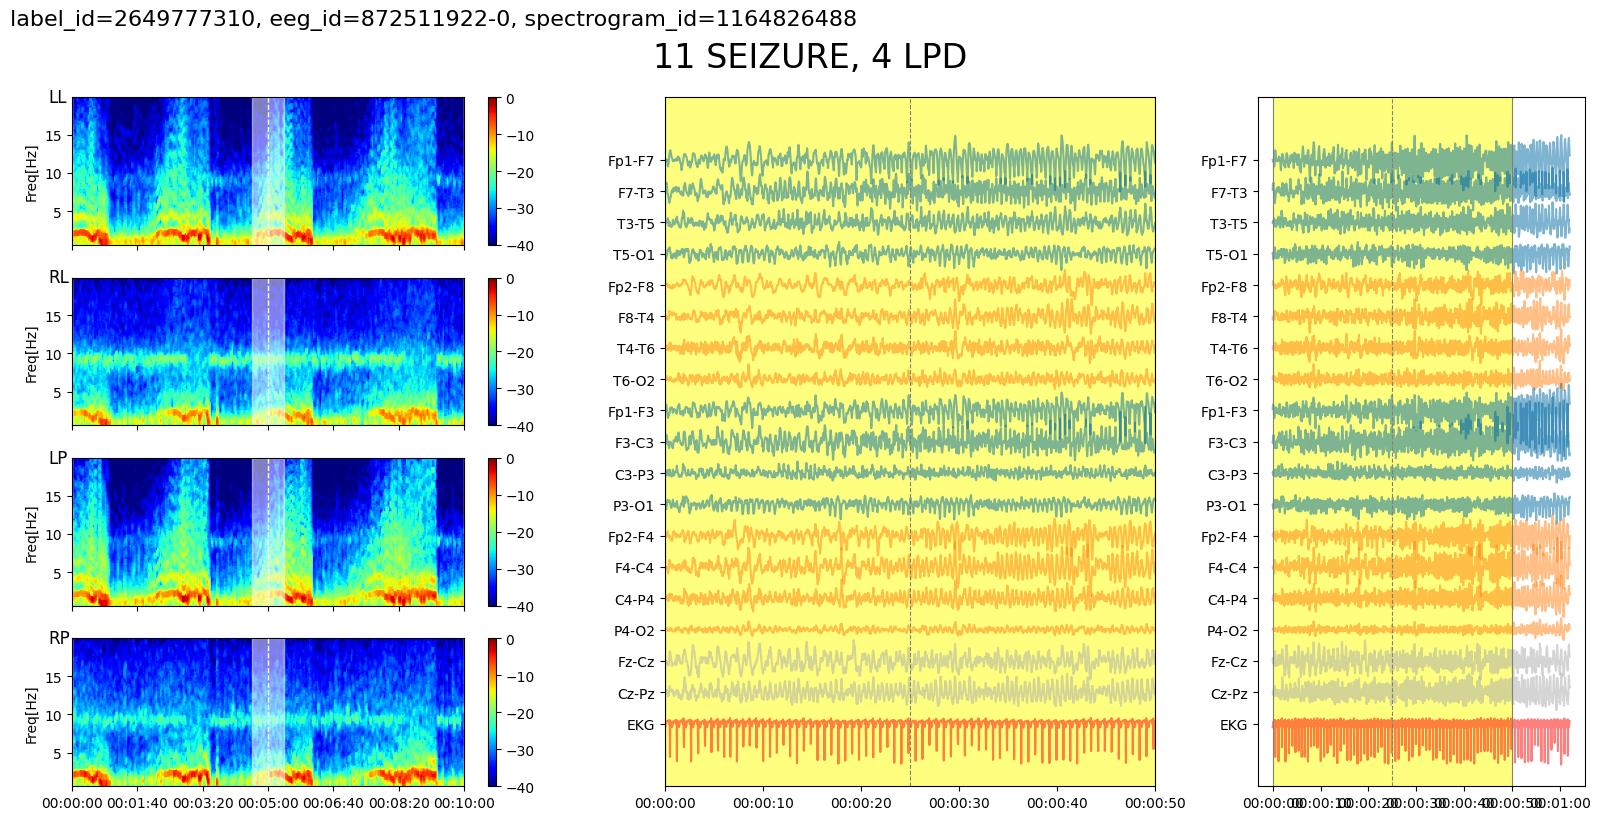

label_id=1426233809, eeg_id=2011795200, eeg_sub_id=7, spectrogram_id=1466529057
spectrogram_offset_sec=38.0, eeg_offset_sec=38.0


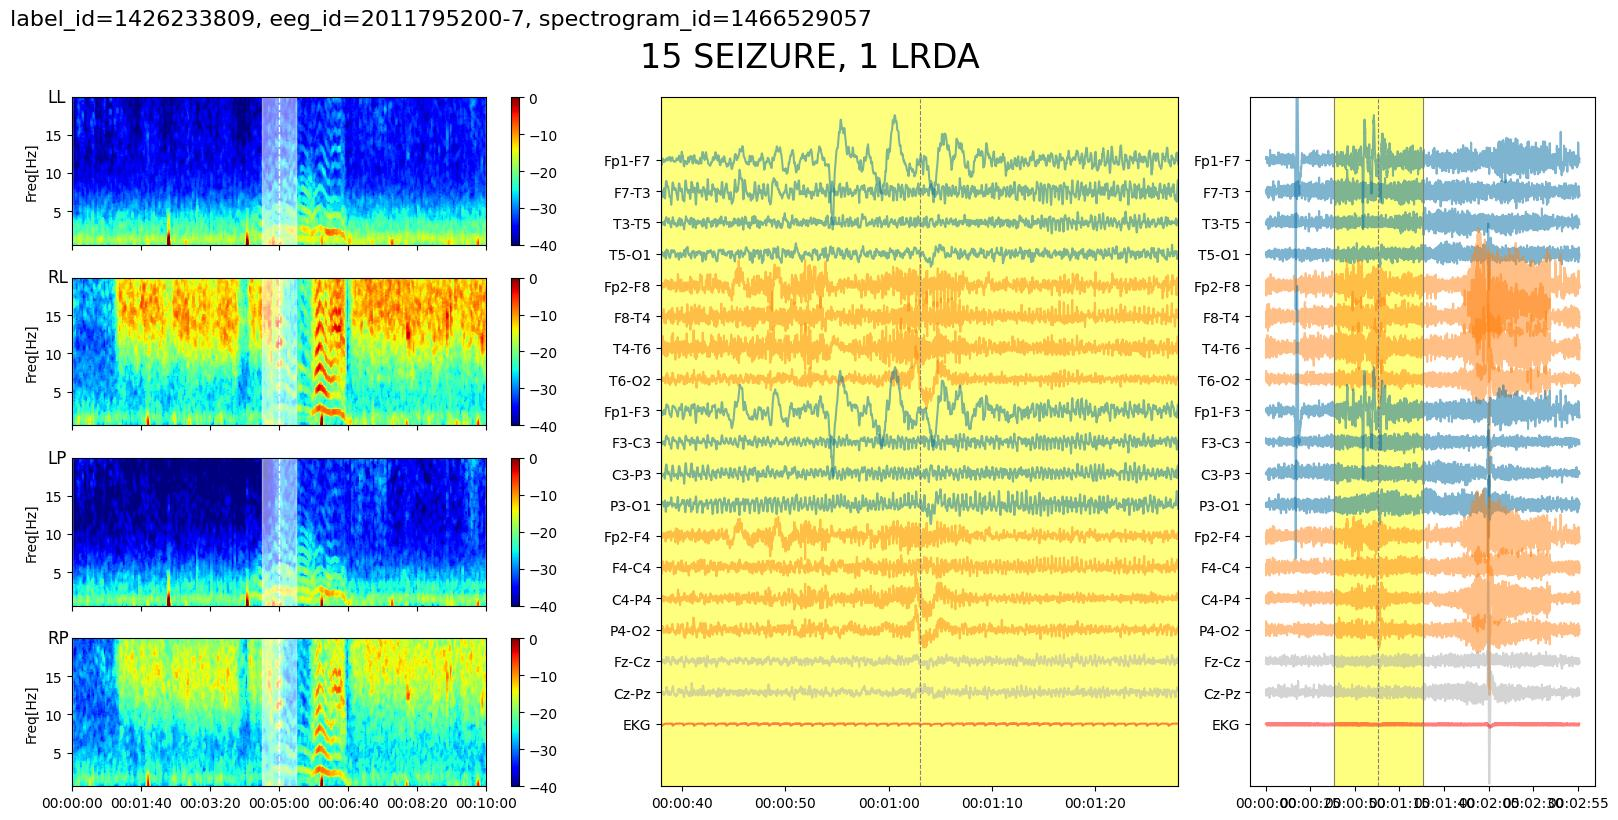

label_id=162686947, eeg_id=2530020793, eeg_sub_id=11, spectrogram_id=731582019
spectrogram_offset_sec=60.0, eeg_offset_sec=60.0


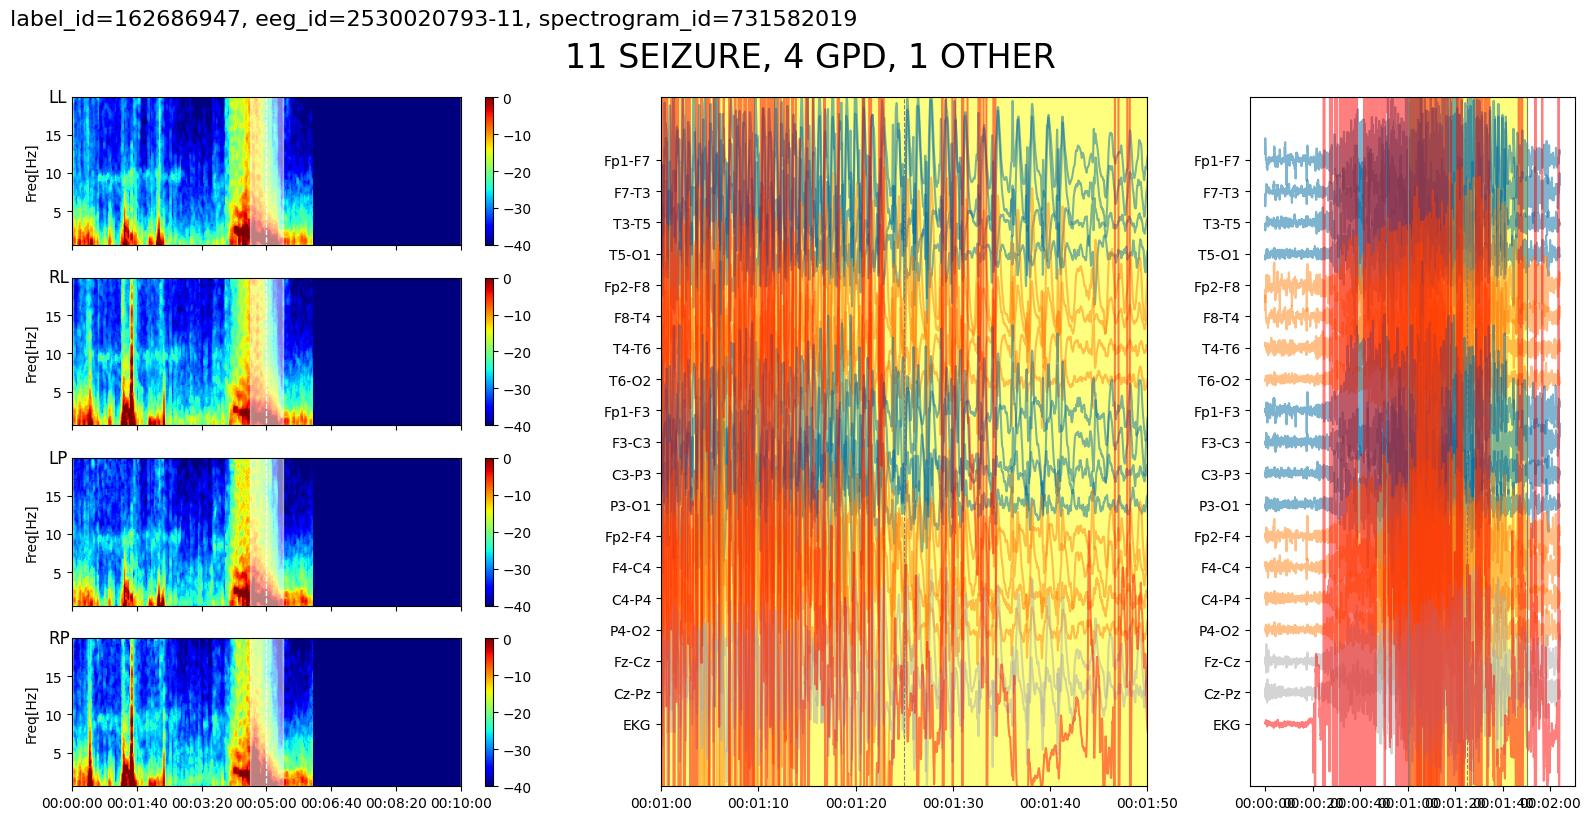

label_id=3772205300, eeg_id=2328924181, eeg_sub_id=4, spectrogram_id=1603231808
spectrogram_offset_sec=18.0, eeg_offset_sec=18.0


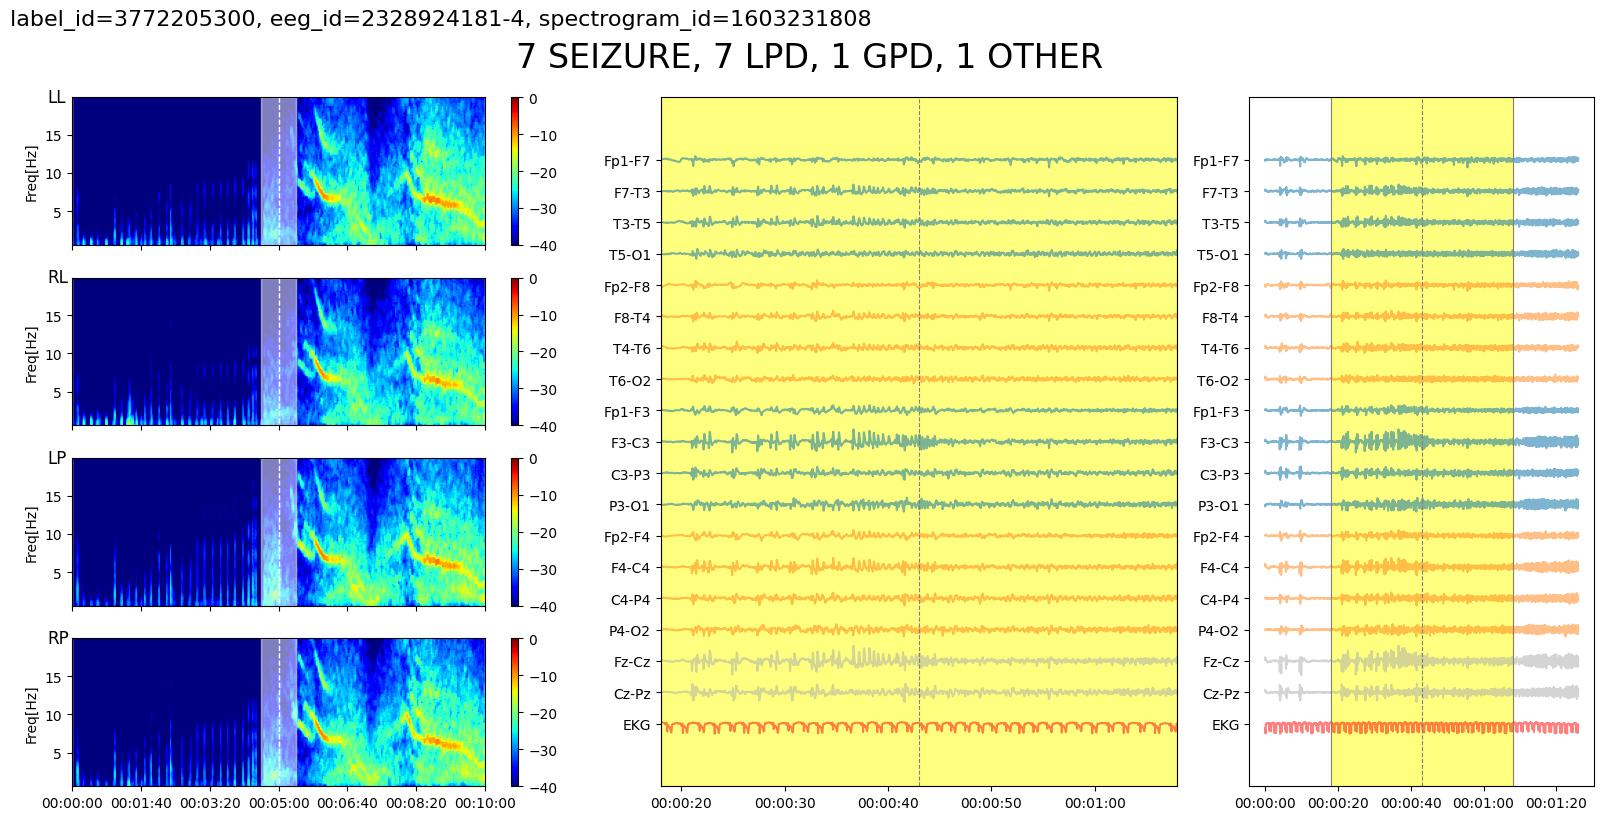

label_id=1321505396, eeg_id=3305862159, eeg_sub_id=15, spectrogram_id=740928446
spectrogram_offset_sec=428.0, eeg_offset_sec=226.0


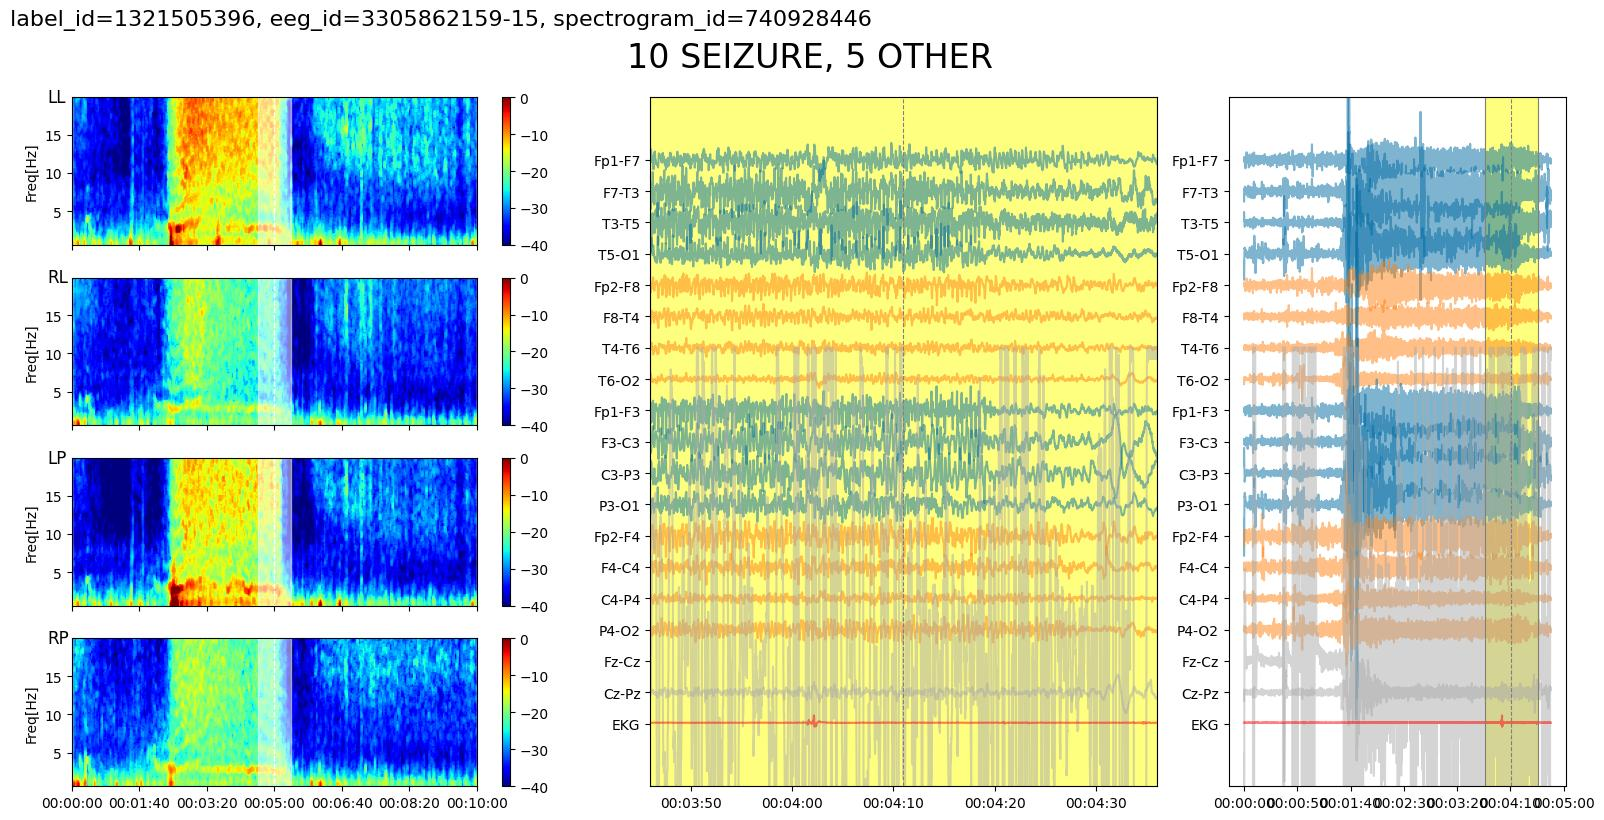

In [12]:
columns = metadata.columns
for row in (
    metadata.filter(
        pl.col("weight").ge(0.3).and_(pl.col("expert_consensus").eq("Seizure"))
    )
    .sample(10)
    .iter_rows()
):
    row = dict(zip(columns, row))
    eeg_id = row["eeg_id"]
    eeg_sub_id = row["eeg_sub_id"]
    plot_data(metadata, eeg_id, eeg_sub_id, cutoff_freqs=(0.5, 50))
    plt.show()

TODO:

- probeごとのnoiseっぽさを表現する特徴を作る
    - rolling_std_in_n_sec
- probeごとの波形をプロットする関数の実装
- 特定のprobeが外れているかどうかを判定するには？

調査必要

- データの前処理方法を確認する(ホストに聞く + 論文に書かれてないか？)
- サンプルごとののダイナミックレンジを知りたい
- 一般的なEEGのPreprocessingについて確認する[1]

## Reference

- [1] http://learn.neurotechedu.com/preprocessing/
